In [2]:
# importing the dependencies
import numpy as np # linear algebra
import pandas as pd # for the dataframe
import tensorflow as tf # for Deep learning
from glob import glob # for file handling
from tqdm import tqdm # for the progress bar
from collections import deque # for simpler implementation of memory

import matplotlib.pyplot as plt
%matplotlib inline


Load the stock prices and set required parameters

In [5]:
# load the csv file
stock_name  = 'MSFT'
path_folder = './data_raw/MSFT.csv'

data = pd.read_csv(path_folder)

# constants
LOG = False
episode_count = 10
window_size = 100
data = data['Close'].values # what our data is
len_data = len(data) - 1 # total information length
batch_size = 32 # minibatch size

# logs
loss_global = []
profits_global = []

Text(0.5, 1.0, 'MSFT')

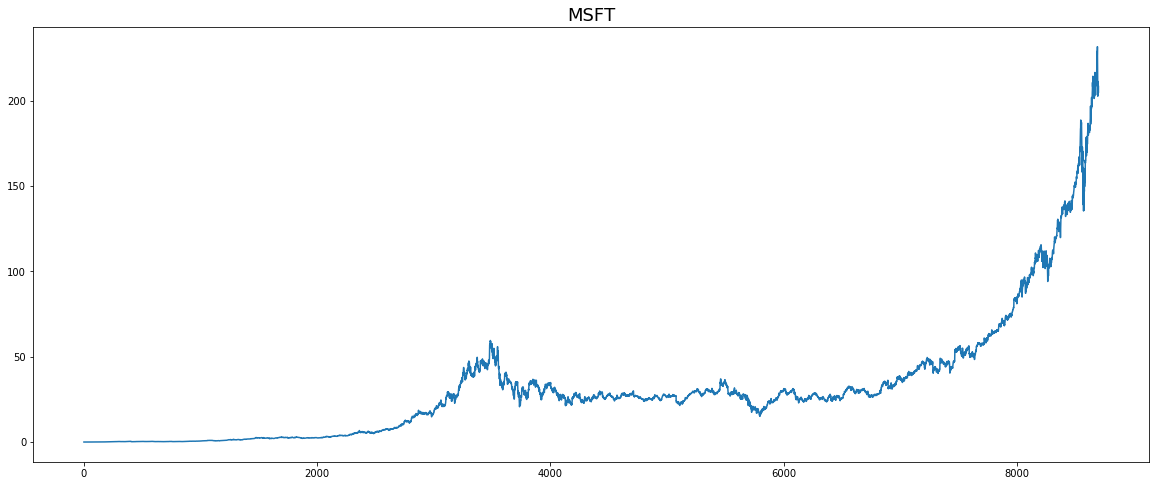

In [6]:
plt.figure(figsize = (20, 8))
plt.plot(data)
plt.title(stock_name  , fontsize = 18)

# Deep Q-Learning algorithm 

In [5]:
class StocksDQN():
    # init functions
    def __init__(self, input_dim, scope, is_eval = False, epsilon_decay_steps = 1000):
        # input_dim: state size
        # is_eval: is being evaluated
        # scope: scope of the model
        self.state_size = input_dim
        self.action_space = 3 # sell, sit, buy
        self.memory = deque(maxlen = 10000)
        self.inventory = [] # holdings that we have
        self.scope = scope # name of scope
        self.is_eval = is_eval # whether in training or deployment
        self.gamma = 0.95 # discount factor

        # greedy-epsilon policy
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay_val = (self.epsilon - self.epsilon_end)/epsilon_decay_steps

        # code to load previously trained model --> skip for now
        # self.model = load_model("models/" + model_name) if is_eval else self._model()
        self._build_model()
        self._build_loss()
        self.initialize_network()

    # inhouse functions
    def _build_model(self):
        self.input_placeholder = tf.placeholder(tf.float32, [None, self.state_size], name = 'inputs')
        self.target_placeholder = tf.placeholder(tf.float32, [None, self.action_space], name = 'target_value')

        # layers
        h1 = tf.contrib.layers.fully_connected(self.input_placeholder, 64)
        h2 = tf.contrib.layers.fully_connected(h1, 32)
        h3 = tf.contrib.layers.fully_connected(h2, 8)
        self.action_pred = tf.contrib.layers.fully_connected(h3, self.action_space)

        # print the values
        print('inputs:', self.input_placeholder)
        print('target_value:', self.target_placeholder)
        print('action_pred:', self.action_pred)

    def _build_loss(self):
        self.loss = tf.reduce_mean(tf.square(self.target_placeholder - self.action_pred))
        print('loss:', self.loss)
        self.update_step = tf.train.AdamOptimizer(0.001).minimize(self.loss)

    # user callable functions
    def initialize_network(self):
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def save_model(self, frozen = False):
        # code to save the model as frozen inference graph (optional) or 
        # checkpoint file (default)
        if frozen:
            # convert to frozen graph here
            model_path = 'some_path'
            print('Model saved at {0}'.format(some_path))
            return
        return

    # operation functions
    def act(self, state):
        if not self.is_eval and np.random.random() <= self.epsilon:
            return np.random.randint(self.action_space)

        # else use the model to predict action
        action_dist = self.sess.run(self.action_pred, feed_dict = {self.input_placeholder: state})
        return np.argmax(action_dist[0])

    def experience_replay(self, batch_size):
        # make the minibatch
        mini_batch = []
        mem_len = len(self.memory)
        for i in range(mem_len - batch_size + 1, mem_len):
            mini_batch.append(self.memory[i])

        # loss log
        loss_log = []

        for state, action, reward, next_state, done in mini_batch:
            target_s = reward
            if not done:
                # get predictions from model
                pred = self.sess.run(self.action_pred, feed_dict = {self.input_placeholder: next_state})

                # get the target value to be fit
                target_s = reward + self.gamma*np.amax(pred[0])

            # target value to be fit upon
            target_y = self.sess.run(self.action_pred, feed_dict = {self.input_placeholder: state})
            target_y[0][action] = target_s

            # train the model
            feed_dict = {self.input_placeholder: state, self.target_placeholder: target_y}
            loss, _ = self.sess.run([self.loss, self.update_step], feed_dict = feed_dict)

            # add to logs
            loss_log.append(loss)

        # reduce the value of epsilon
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_decay_val

        # return loss
        return loss_log

### To get price of profit, stock prices according to window size

Below is the code for some helper functions

In [ ]:
# function to properly return the string of price
def format_price(price):
    return ("-$" if price < 0 else "$") + "{0:.2f}".format(abs(price))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

# function to get the state
def get_state(data, t, n):
    d = t - n + 1
    if d >= 0:
        block = data[d:t+1]
    else:
        # pad with t0
        block = -d*[data[0]] + data[0:t+1].tolist()
    
    # get results
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    
    # return numpy array
    return np.array([res])

In [7]:
# define the agent
agent = StocksDQN(window_size, 'model_pre')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

inputs: Tensor("inputs:0", shape=(?, 100), dtype=float32)
target_value: Tensor("target_value:0", shape=(?, 3), dtype=float32)
action_pred: Tensor("fully_connected_3/Relu:0", shape=(?, 3), dtype=float32)
loss: Tensor("Mean:0", shape=(), dtype=float32)


In [8]:
# run things
for e in range(episode_count):
    state = get_state(data, 0, window_size + 1)

    # init values for new episode
    total_profit = 0.0 # total profit in this epoch
    agent.inventory = [] # reset the inventory
    total_loss = [] # at each step what was the total loss
    mean_loss = [] # at each step what was the mean loss

    for t in tqdm(range(len_data)):
        action = agent.act(state)

        # next state
        next_state = get_state(data, t + 1, window_size + 1)
        reward = 0

        # now go according to actions
        if action == 2:
            # buy
            agent.inventory.append(data[t])
            if LOG:
                print('Buy:' + format_price(data[t]))


        elif action == 0 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0) # remove the first element and return the value
            profit = data[t] - bought_price # profit this iteration
            reward = max(data[t] - bought_price, 0) # reward
            total_profit += profit # add to total profit
            if LOG:
                print("Sell: " + format_price(data[t]) + " | Profit: " + format_price(profit))

        # condition for finish
        done = t == len_data - 1
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done and LOG:
            print("Total Profit: " + format_price(total_profit))

        # train the model
        if len(agent.memory) > batch_size:
            losses = agent.experience_replay(batch_size)
            total_loss.append(np.sum(losses))
            mean_loss.append(np.mean(losses))

    # add the mean loss to global loss
    loss_global.append(np.mean(mean_loss))
    profits_global.append(total_profit)
    
    print('[*]Episode: {0}, loss: {1}, profits: {2}'.format(e, loss_global[-1], profits_global[-1]))

100%|██████████| 4935/4935 [02:24<00:00, 34.22it/s][*]Episode: 9, loss: 0.03333945572376251, profits: 53.63941100000009



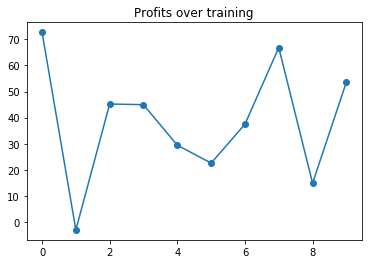

In [9]:
plt.title('Profits over training')
plt.plot(profits_global, '-o')